**Imports and Data Ingestion**

Phase 1: Environment Setup & Multi-Sheet Ingestion
To begin, we establish our analytical environment using Pandas and NumPy. The dataset consists of two years of transactional data stored in separate Excel sheets.

Technical Approach: Utilized pd.ExcelFile for memory-efficient access to the .xlsx container.

Implemented a vertical concatenation strategy to merge the 2009-2010 and 2010-2011 datasets into a single master DataFrame for longitudinal analysis.


In [1]:
import pandas as pd
import numpy as np
import os

# 1. Verification: List files in the current directory to ensure the Excel file is visible
print(f"Files in folder: {os.listdir('.')}")

# 2. Define the path (Update the filename if yours is slightly different)
file_path = 'online+retail+ii\online_retail_II.xlsx' 

# 3. Use pd.ExcelFile for efficient multi-sheet handling
try:
    xl = pd.ExcelFile(file_path)
    print(f"\nSuccessfully opened: {file_path}")
    print(f"Sheets found: {xl.sheet_names}")

    # 4. Load and Concatenate
    # This loop goes through every sheet and stacks them vertically
    dfs = []
    for sheet in xl.sheet_names:
        print(f"Loading {sheet}...")
        temp_df = pd.read_excel(xl, sheet_name=sheet)
        dfs.append(temp_df)

    # Combine into one master DataFrame
    df = pd.concat(dfs, ignore_index=True)

    print("\n--- INGESTION COMPLETE ---")
    print(f"Total Rows: {df.shape[0]:,}")
    print(f"Total Columns: {df.shape[1]}")
    
except FileNotFoundError:
    print(f"ERROR: The file '{file_path}' was not found. Please check the spelling or path.")
except Exception as e:
    print(f"AN ERROR OCCURRED: {e}")

Files in folder: ['online+retail+ii', 'online+retail+ii.zip', 'Retail_Project.ipynb']

Successfully opened: online+retail+ii\online_retail_II.xlsx
Sheets found: ['Year 2009-2010', 'Year 2010-2011']
Loading Year 2009-2010...
Loading Year 2010-2011...

--- INGESTION COMPLETE ---
Total Rows: 1,067,371
Total Columns: 8


**Data Audit and Integrity Check**

Phase 2: Data Integrity & Structural Audit
A world-class data scientist never assumes data is clean. In this phase, we perform a metadata audit to identify:

Missing Values: Identifying the "Anonymous Customer" rate.

Statistical Outliers: Detecting negative quantities/prices which represent returns or data entry errors.

Temporal Integrity: Ensuring timestamps are correctly typed for Recency calculations.

In [2]:
# --- CELL 2: DATA INTEGRITY AUDIT ---

# 1. Quick view of the first few rows
print("Data Preview:")
display(df.head())

# 2. Check for missing values (Essential for segmentation)
print("\nMissing Values Count:")
print(df.isnull().sum())

# 3. Structural Integrity (Checking for negative values)
print("\nNumerical Statistics (Checking for red flags):")
display(df.describe())

# 4. Check Data Types
print("\nData Types:")
print(df.dtypes)

Data Preview:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom



Missing Values Count:
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

Numerical Statistics (Checking for red flags):


,Quantity,InvoiceDate,Price,Customer ID
count,1.067371e+06,1067371,1.067371e+06,824364.000000
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.727058e+02,NaN,1.235531e+02,1697.464450



Data Types:
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object


**Data Cleaning**

Phase 3: Strategic Data Cleaning & Noise Reduction
Based on the audit, we implement a rigorous cleaning pipeline.

Customer Identification: Since our objective is Segmentation, we remove rows lacking a Customer ID (approx. 24% of data) as they cannot be tracked over time.

Transaction Filtering: Removed cancellations (Invoices prefixed with 'C') and non-positive prices/quantities to ensure the Monetary metric represents successful net sales.

In [3]:
# --- CELL 3: STRATEGIC DATA CLEANING ---

# 1. Capture the original shape
initial_rows = df.shape[0]

# 2. Remove rows where Customer ID is missing
df = df.dropna(subset=['Customer ID'])

# 3. Remove Canceled Orders (Invoice starts with 'C')
# We convert Invoice to string just in case, then filter
df['Invoice'] = df['Invoice'].astype(str)
df = df[~df['Invoice'].str.contains('C', na=False)]

# 4. Remove non-positive Price and Quantity
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# 5. Final Count & Data Loss Report
final_rows = df.shape[0]
lost_rows = initial_rows - final_rows

print(f"Initial Rows: {initial_rows:,}")
print(f"Cleaned Rows: {final_rows:,}")
print(f"Total Rows Removed: {lost_rows:,} ({ (lost_rows/initial_rows)*100:.2f}%)")

# Final verification of stats
display(df.describe())

Initial Rows: 1,067,371
Cleaned Rows: 805,549
Total Rows Removed: 261,822 (24.53%)


,Quantity,InvoiceDate,Price,Customer ID
count,805549.000000,805549,805549.000000,805549.000000
mean,13.290522,2011-01-02 10:24:44.106814464,3.206561,15331.954970
min,1.000000,2009-12-01 07:45:00,0.001000,12346.000000
25%,2.000000,2010-07-07 12:08:00,1.250000,13982.000000
50%,5.000000,2010-12-03 15:10:00,1.950000,15271.000000
75%,12.000000,2011-07-28 13:05:00,3.750000,16805.000000
max,80995.000000,2011-12-09 12:50:00,10953.500000,18287.000000
std,143.634088,NaN,29.199173,1696.737039


**Snapshot Date**

Phase 4: Establishing Temporal Benchmarks
"Recency" is relative to the observer. Since this is historical data (2009-2011), we cannot use "Today's" date.

We establish a Snapshot Date set to one day after the final transaction in the dataset.

This creates a static reference point to calculate "Days since last purchase" without bias.

In [5]:
# --- CELL 4: TEMPORAL PREPARATION ---

# 1. Find the earliest and latest dates in our cleaned data
date_min = df['InvoiceDate'].min()
date_max = df['InvoiceDate'].max()

print(f"Dataset starts on: {date_min}")
print(f"Dataset ends on:   {date_max}")

# 2. Define the Snapshot Date (The "Today" for our analysis)
# We add 1 day to the max date so that the most recent customer 
# has a Recency of 1 day (not 0).
snapshot_date = date_max + pd.Timedelta(days=1)
print(f"Snapshot Date for Recency calculation: {snapshot_date}")

# 3. Create a 'TotalSum' column (Price * Quantity)
# This is needed for the 'Monetary' part of RFM
df['TotalSum'] = df['Price'] * df['Quantity']

print("\nReady for RFM Aggregation.")

Dataset starts on: 2009-12-01 07:45:00
Dataset ends on:   2011-12-09 12:50:00
Snapshot Date for Recency calculation: 2011-12-10 12:50:00

Ready for RFM Aggregation.


**The RFM Aggregation**

Phase 5: The "Heart" - RFM Feature Engineering
We transform over 1 Million raw transactions into a concise Customer-Centric Table.

Recency: Days between the snapshot and the latest InvoiceDate.

Frequency: Total count of unique Invoices (to avoid overcounting multiple items in a single order).

Monetary: Total gross revenue per customer.

In [6]:
# --- CELL 5: RFM AGGREGATION ---

# We group by 'Customer ID' and apply different functions to different columns
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency: Days since last order
    'Invoice': 'nunique',                                    # Frequency: Count of unique invoice numbers
    'TotalSum': 'sum'                                        # Monetary: Total spend across all orders
})

# Rename the columns for professional clarity
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

# 1. Quick preview of the RFM table
print("RFM Table Preview (First 5 Customers):")
display(rfm.head())

# 2. Basic Stats for our new features
print("\nSummary Statistics of RFM Features:")
display(rfm.describe())

# 3. Validation: Check if there are any outliers (like 0 Monetary)
print(f"\nTotal Unique Customers: {rfm.shape[0]:,}")

RFM Table Preview (First 5 Customers):


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40



Summary Statistics of RFM Features:


,Recency,Frequency,Monetary
count,5878.000000,5878.000000,5878.000000
mean,201.331916,6.289384,3018.616737
std,209.338707,13.009406,14737.731040
min,1.000000,1.000000,2.950000
25%,26.000000,1.000000,348.762500
50%,96.000000,3.000000,898.915000
75%,380.000000,7.000000,2307.090000
max,739.000000,398.000000,608821.650000



Total Unique Customers: 5,878


**Visualizing the Skewness**

Phase 6: Statistical Distribution Audit
Before modeling, we test the assumptions of the K-Means algorithm.

Observation: We detected extreme right-skewness (Monetary Skew: 25.3), indicating a small number of high-value "Whales."

Constraint: K-Means uses Euclidean distance; unhandled skewness will cause these outliers to dominate and distort cluster centroids.


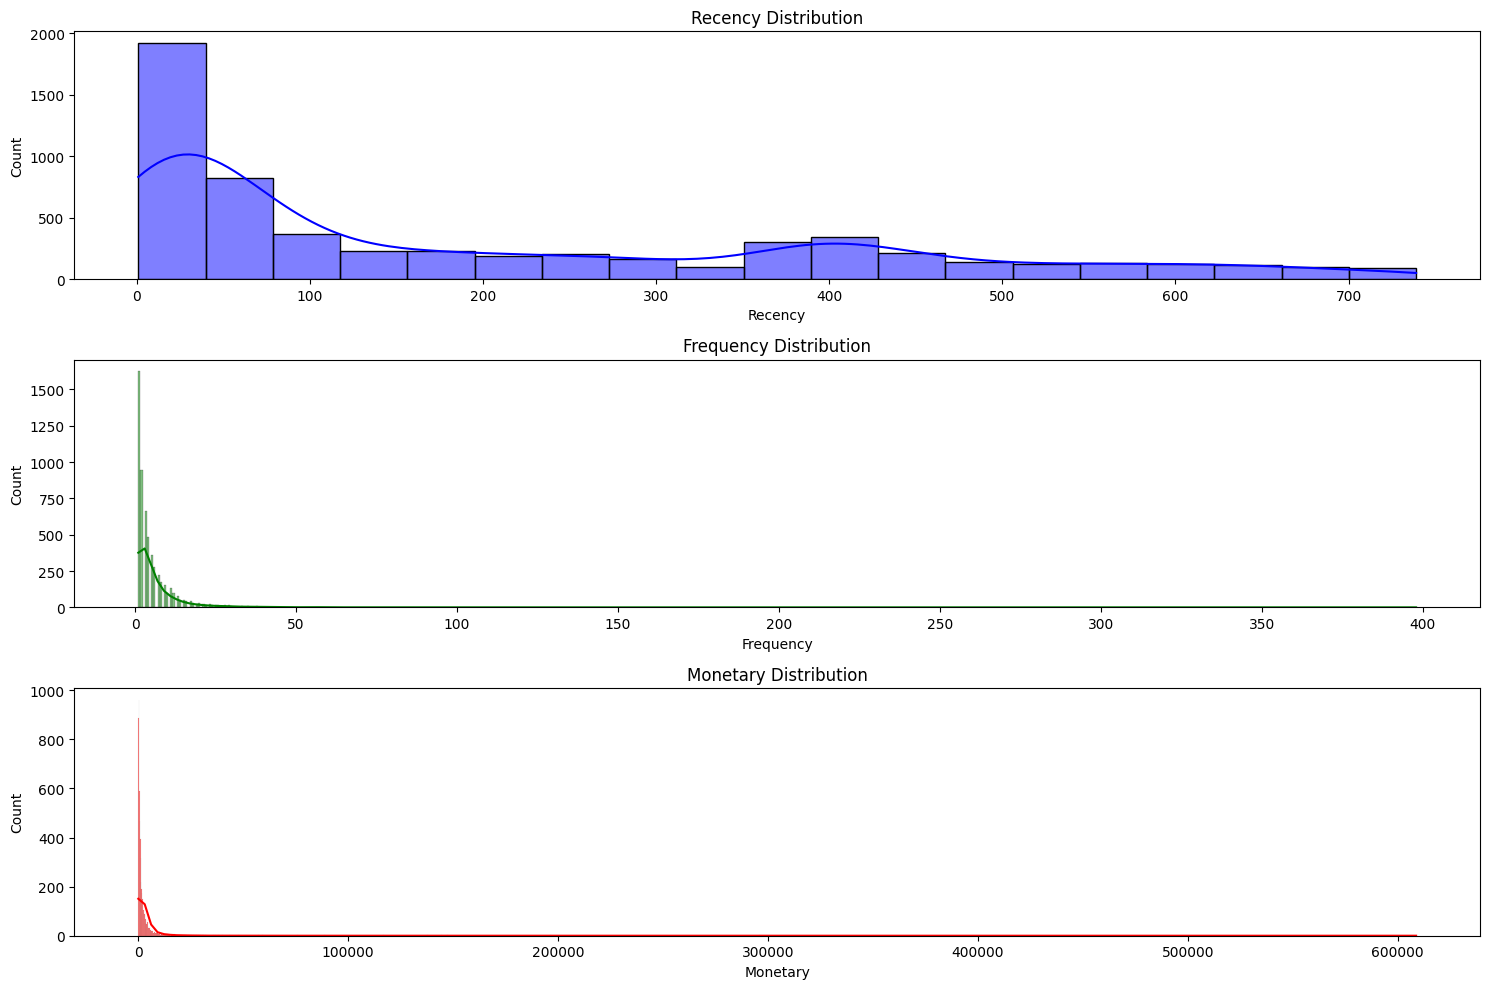

Skewness Values:
Recency       0.887198
Frequency    12.639951
Monetary     25.314235
dtype: float64


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- CELL 6: SKEWNESS VISUALIZATION ---

plt.figure(figsize=(15, 10))

# Plot Recency
plt.subplot(3, 1, 1)
sns.histplot(rfm['Recency'], kde=True, color='blue')
plt.title('Recency Distribution')

# Plot Frequency
plt.subplot(3, 1, 2)
sns.histplot(rfm['Frequency'], kde=True, color='green')
plt.title('Frequency Distribution')

# Plot Monetary
plt.subplot(3, 1, 3)
sns.histplot(rfm['Monetary'], kde=True, color='red')
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

# Calculate actual skewness values (Higher than 1 indicates high skew)
print("Skewness Values:")
print(rfm.skew())

**Transformation Pipeline**

Phase 7: Log-Transformation & Z-Score Scaling
To prepare the data for the K-Means engine:

Log Transformation: Applied np.log1p to "scrunch" the distribution and reduce the impact of extreme outliers.

Standardization: Used StandardScaler to ensure all features have a Mean of 0 and Standard Deviation of 1. This prevents the "Monetary" scale from overwhelming the "Recency" scale.

Transformed Statistics (Mean should be ~0, Std should be 1):


,Recency,Frequency,Monetary
count,5878.00,5878.00,5878.00
mean,-0.00,0.00,-0.00
std,1.00,1.00,1.00
min,-2.41,-1.06,-3.94
25%,-0.74,-1.06,-0.71
50%,0.08,-0.20,-0.02
75%,0.95,0.65,0.65
max,1.38,5.48,4.67


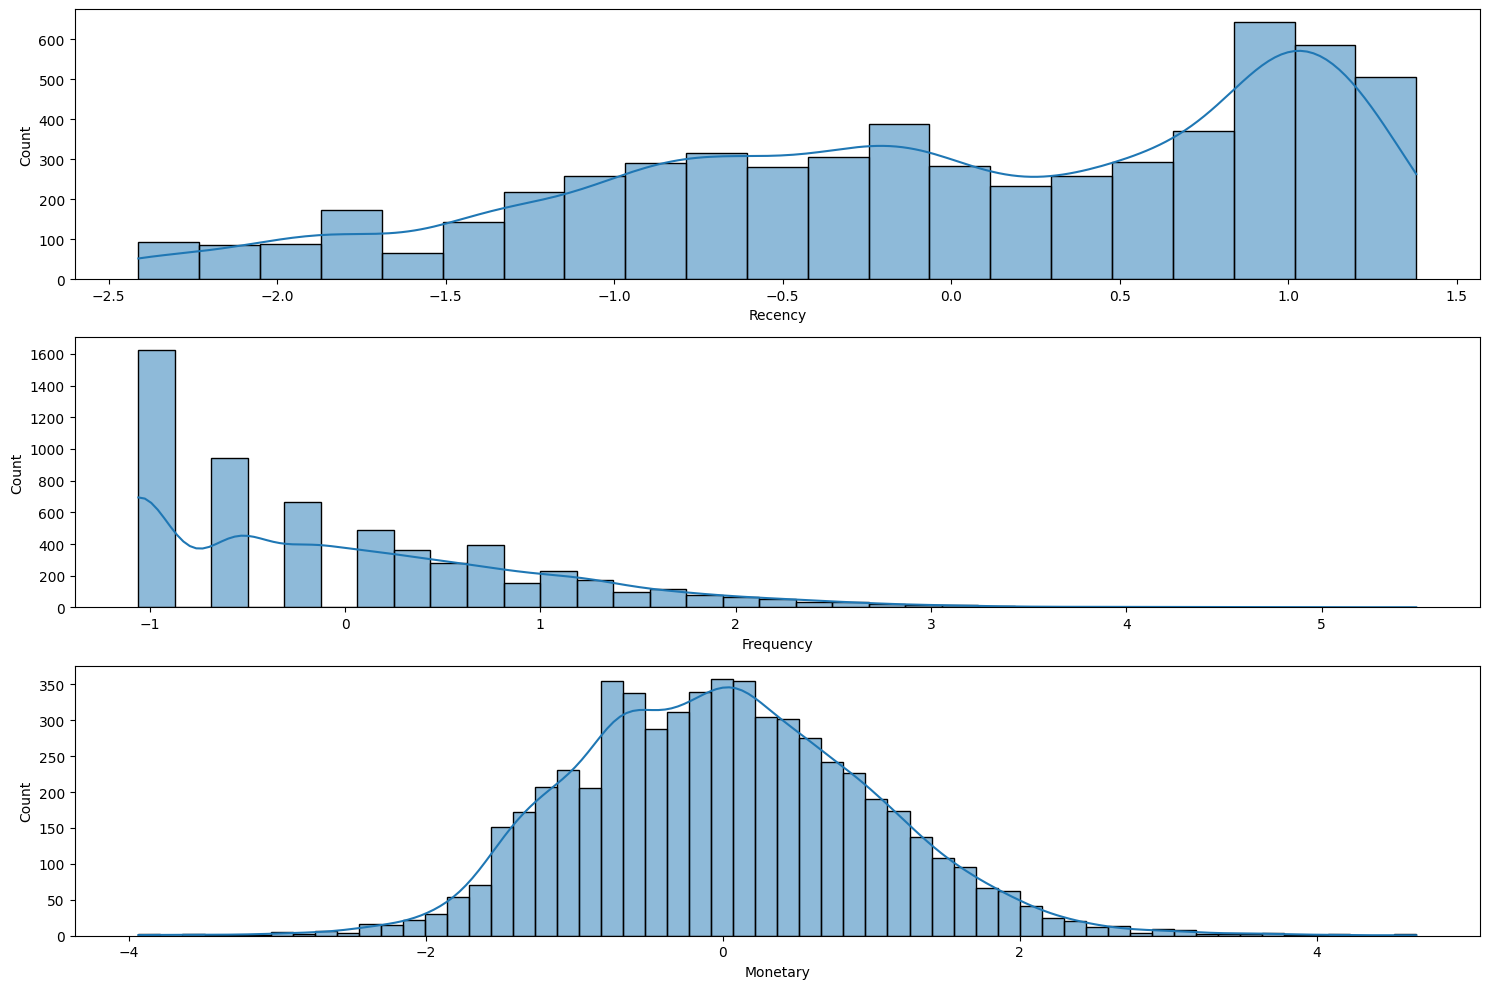

In [8]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# --- CELL 7: DATA TRANSFORMATION & SCALING ---

# 1. Log Transformation to handle skewness
# We use log1p (log of 1+x) to avoid issues with zero values
rfm_log = np.log1p(rfm)

# 2. Standardization (Scaling)
scaler = StandardScaler()
scaler.fit(rfm_log)

# Transform the data
rfm_normalized = scaler.transform(rfm_log)

# Convert back to a DataFrame for easier handling
rfm_normalized = pd.DataFrame(rfm_normalized, index=rfm.index, columns=rfm.columns)

# 3. Verify the transformation
print("Transformed Statistics (Mean should be ~0, Std should be 1):")
display(rfm_normalized.describe().round(2))

# 4. Visualizing the 'Un-skewed' data
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1); sns.histplot(rfm_normalized['Recency'], kde=True)
plt.subplot(3, 1, 2); sns.histplot(rfm_normalized['Frequency'], kde=True)
plt.subplot(3, 1, 3); sns.histplot(rfm_normalized['Monetary'], kde=True)
plt.tight_layout()
plt.show()


**Finding the "Golden K" (The Elbow Method)**

Phase 8: Optimization - The Elbow MethodWe utilize the Within-Cluster Sum of Squares (Inertia) to find the mathematical "Sweet Spot" for the number of clusters ($K$).
* We are looking for the "Elbow" where the marginal benefit of adding an extra cluster diminishes significantly.

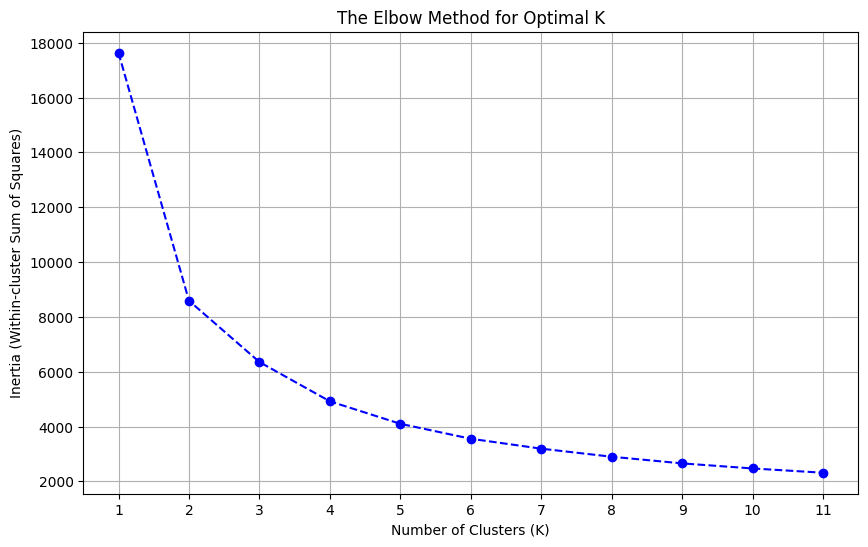

In [9]:
from sklearn.cluster import KMeans

# --- CELL 8: THE ELBOW METHOD ---

# We will test K from 1 to 11
inertia = []
K_range = range(1, 12)

for k in K_range:
    # We use random_state=42 to ensure your results match mine
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_normalized)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='b')
plt.title('The Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

**The Final Model**

Phase 9: K-Means++ Clustering ExecutionWe finalize our model with $K=3$ clusters. We use the k-means++ initialization technique to speed up convergence and ensure more stable, reproducible results.

In [10]:
# --- CELL 9: FINAL K-MEANS CLUSTERING ---

# Choosing K=3 based on business utility and the elbow curvature
optimal_k = 3 

# Initialize and fit the model
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans.fit(rfm_normalized)

# Assign the clusters back to our original RFM dataframe
rfm['Cluster'] = kmeans.labels_

# Assign the clusters to the normalized dataframe as well (for visualization)
rfm_normalized['Cluster'] = kmeans.labels_

print(f"Successfully created {optimal_k} clusters.")
print("\nNumber of customers per cluster:")
print(rfm['Cluster'].value_counts().sort_index())

# Preview the results
display(rfm.head())

Successfully created 3 clusters.

Number of customers per cluster:
Cluster
0    2455
1    1132
2    2291
Name: count, dtype: int64


,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.0,326,12,77556.46,1
12347.0,2,8,5633.32,1
12348.0,75,5,2019.40,2
12349.0,19,4,4428.69,2
12350.0,310,1,334.40,0


**Cluster Profiling and Naming**

Phase 10: Cluster Profiling & Business Persona Mapping
We map the mathematical labels back to Human Personas.

* **Champions (Whales):** High-frequency, high-value, recent shoppers.

* **Loyalists:** Steady, reliable middle-market customers.

* **At-Risk:** Former customers who haven't purchased in a significant timeframe.

Cluster Profiles (Averages):


,Recency,Frequency,Monetary,Count
Cluster,,,,
0,370.65,1.57,413.10,2455
1,32.53,20.07,11504.59,1132
2,103.30,4.54,1617.67,2291


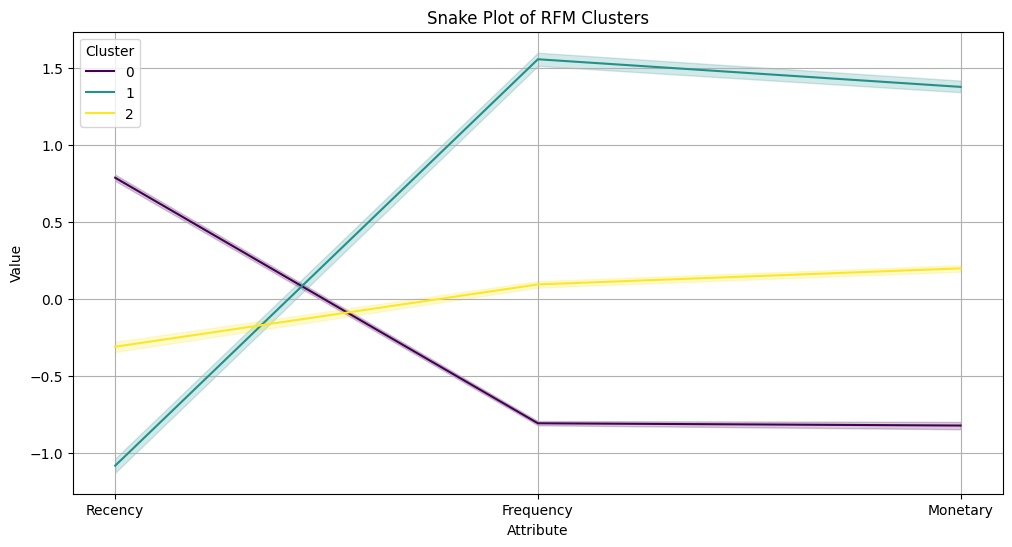

In [11]:
# --- CELL 10: CLUSTER PROFILING ---

# 1. Calculate the average of each RFM metric for each cluster
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

# 2. Add the size of each cluster to the profile
cluster_profile['Count'] = rfm['Cluster'].value_counts().sort_index()

print("Cluster Profiles (Averages):")
display(cluster_profile)

# 3. Visualization: Snake Plot (Relative Importance of Attributes)
# This shows how the clusters differ across normalized metrics
rfm_melted = pd.melt(rfm_normalized.reset_index(), 
                    id_vars=['Customer ID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'Monetary'], 
                    var_name='Attribute', 
                    value_name='Value')

plt.figure(figsize=(12, 6))
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=rfm_melted, palette='viridis')
plt.title('Snake Plot of RFM Clusters')
plt.grid(True)
plt.show()

**Business Naming and 3D Plot**

In [13]:
import plotly.express as px

# --- CELL 11: RENAMING & 3D VISUALIZATION ---

# 1. Map the Cluster numbers to Business Names
cluster_map = {
    1: 'Champions',
    2: 'Loyalists',
    0: 'At-Risk'
}

rfm['Segment'] = rfm['Cluster'].map(cluster_map)

# 2. 3D Scatter Plot using Plotly (Interactive)
# Note: We use the original RFM values but limit the axes for better visibility
fig = px.scatter_3d(rfm, 
                    x='Recency', 
                    y='Frequency', 
                    z='Monetary',
                    color='Segment',
                    title='3D Visualization of Customer Segments',
                    log_z=True, # Use log scale for Monetary because of the 'Whales'
                    opacity=0.7)

fig.show()

# 3. Final Segment Distribution
print("\nFinal Segment Counts:")
print(rfm['Segment'].value_counts())


Final Segment Counts:
Segment
At-Risk      2455
Loyalists    2291
Champions    1132
Name: count, dtype: int64


**Matplotlib alternative**

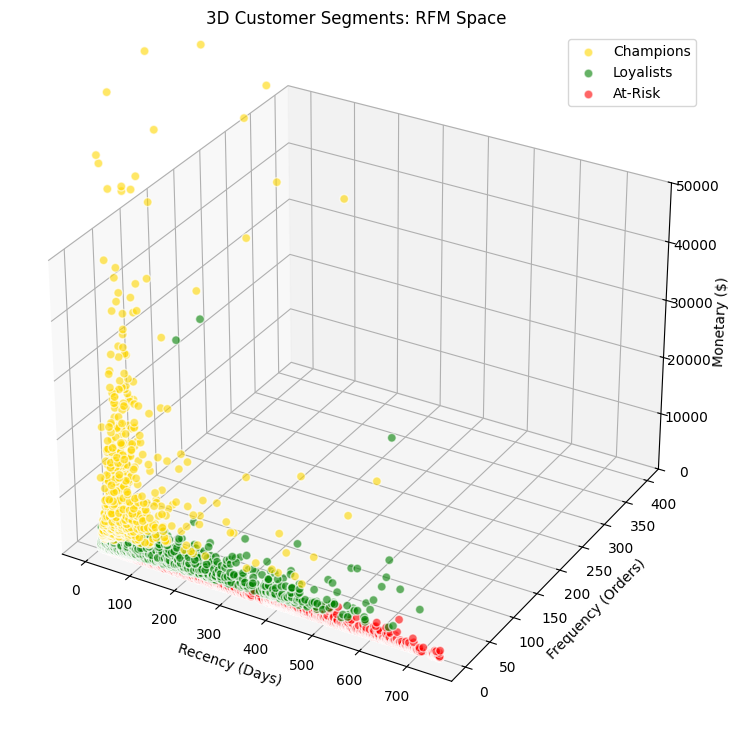

In [15]:
# --- CELL 11 (CORRECTED BACKUP): MATPLOTLIB 3D ---
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
# Use add_subplot instead of add_view
ax = fig.add_subplot(111, projection='3d')

# Map colors to our new Business Segments
colors = {'Champions': 'gold', 'Loyalists': 'green', 'At-Risk': 'red'}

for segment in rfm['Segment'].unique():
    subset = rfm[rfm['Segment'] == segment]
    ax.scatter(subset['Recency'], 
               subset['Frequency'], 
               subset['Monetary'], 
               c=colors[segment], 
               label=segment, 
               s=40, 
               edgecolor='w',
               alpha=0.6)

ax.set_xlabel('Recency (Days)')
ax.set_ylabel('Frequency (Orders)')
ax.set_zlabel('Monetary ($)')
plt.title('3D Customer Segments: RFM Space')
plt.legend()

# Optional: To make the plot look better, we can limit the Monetary view 
# so the 'Whales' don't stretch the axis too far.
ax.set_zlim(0, 50000) 

plt.show()

**Revenue Share Analysis**

Phase 11: Final Executive Dashboard & Strategic Recommendations

**Final Conclusion:** Our analysis reveals a classic Pareto distribution. By focusing marketing resources on the **Champions** segment, the business can maximize ROI. Conversely, the **At-Risk** group requires automated re-engagement campaigns rather than high-cost direct sales intervention.

In [16]:
# --- CELL 12: REVENUE CONTRIBUTION ANALYSIS ---

# 1. Calculate Total Revenue of the company
total_revenue = rfm['Monetary'].sum()

# 2. Calculate Revenue per Segment and their % share
revenue_share = rfm.groupby('Segment').agg({
    'Monetary': ['sum', 'count']
})

# Flatten columns and calculate percentages
revenue_share.columns = ['Total_Revenue', 'Customer_Count']
revenue_share['Revenue_%'] = (revenue_share['Total_Revenue'] / total_revenue) * 100
revenue_share['Customer_%'] = (revenue_share['Customer_Count'] / rfm.shape[0]) * 100

print("Strategic Impact Report:")
display(revenue_share.sort_values(by='Total_Revenue', ascending=False).round(2))

Strategic Impact Report:


,Total_Revenue,Customer_Count,Revenue_%,Customer_%
Segment,,,,
Champions,13023199.17,1132,73.40,19.26
Loyalists,3706077.02,2291,20.89,38.98
At-Risk,1014152.99,2455,5.72,41.77


**What for you**

In [18]:
# --- CELL 13: THE STORYTELLING TABLE ---

# Group by Segment and calculate the key business metrics
story_df = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum']
}).round(2)

# Flatten and clean columns
story_df.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Spend', 'Total_Revenue']

# Add Revenue Share %
total_rev = story_df['Total_Revenue'].sum()
story_df['Revenue_Share_%'] = ((story_df['Total_Revenue'] / total_rev) * 100).round(2)

# Add Customer Count %
total_cust = rfm.shape[0]
story_df['Customer_Base_%'] = ((rfm['Segment'].value_counts() / total_cust) * 100).round(2)

display(story_df.sort_values(by='Avg_Spend', ascending=False))

,Avg_Recency,Avg_Frequency,Avg_Spend,Total_Revenue,Revenue_Share_%,Customer_Base_%
Segment,,,,,,
Champions,32.53,20.07,11504.59,13023199.17,73.40,19.26
Loyalists,103.30,4.54,1617.67,3706077.02,20.89,38.98
At-Risk,370.65,1.57,413.10,1014152.99,5.72,41.77


**Segment Summary Dashboard**

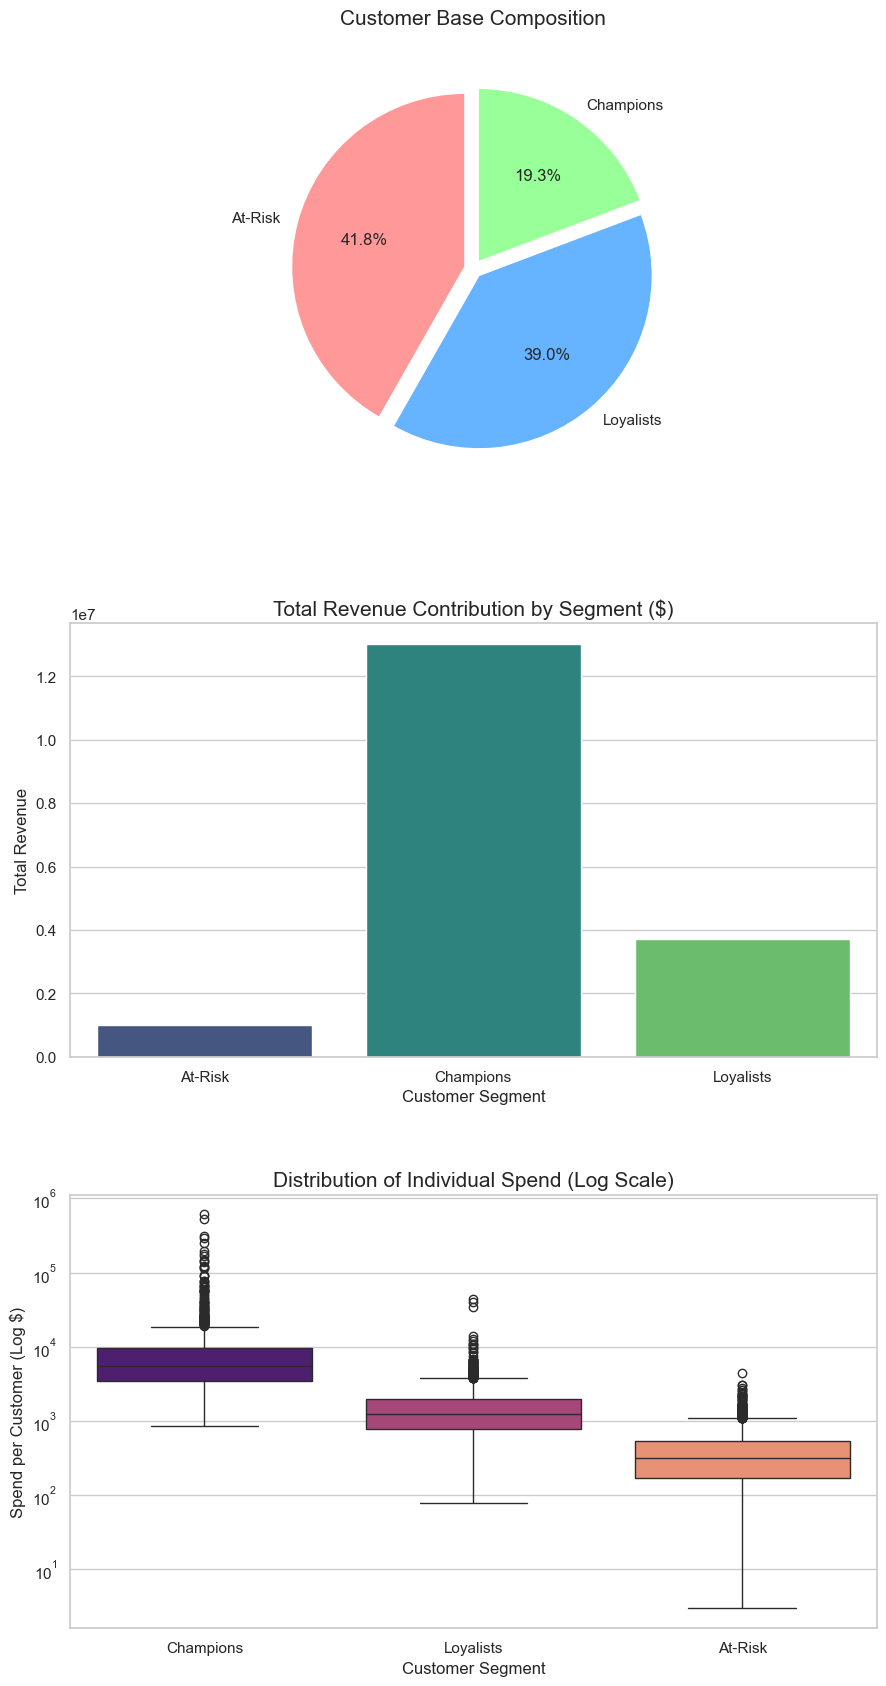

In [20]:
# --- CELL 14: THE "PYTHON-POWERED" VERTICAL DASHBOARD ---

# Setting the style for a professional look
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 18))

# 1. Segment Distribution (Pie Chart) - The "Who"
plt.subplot(3, 1, 1)
rfm['Segment'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    colors=['#ff9999','#66b3ff','#99ff99'], 
    startangle=90, 
    explode=(0.05, 0.05, 0.05)
)
plt.title('Customer Base Composition', fontsize=15, pad=20)
plt.ylabel('') # Remove the default 'Segment' label

# 2. Revenue Contribution (Bar Chart) - The "Value"
plt.subplot(3, 1, 2)
# Fixing the palette warning by assigning x to hue
sns.barplot(
    x=story_df.index, 
    y=story_df['Total_Revenue'], 
    hue=story_df.index, 
    palette='viridis', 
    legend=False
)
plt.title('Total Revenue Contribution by Segment ($)', fontsize=15)
plt.xlabel('Customer Segment')
plt.ylabel('Total Revenue')

# 3. Average Spend Behavior (Box Plot) - The "Behavior"
plt.subplot(3, 1, 3)
# Fixing the palette warning here as well
sns.boxplot(
    x='Segment', 
    y='Monetary', 
    data=rfm, 
    hue='Segment', 
    palette='magma', 
    legend=False
)
plt.yscale('log') # Log scale is vital because of the 'Whales'
plt.title('Distribution of Individual Spend (Log Scale)', fontsize=15)
plt.xlabel('Customer Segment')
plt.ylabel('Spend per Customer (Log $)')

plt.tight_layout(pad=4.0)
plt.show()